## Benchmark AutoEncoder

## 1. Load data & model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
from torchsummary import summary
from datasets import Dataset, Features, Array2D, Value, load_dataset, load_from_disk
from random import randrange
import math
import json

In [8]:
loaded_data = load_from_disk(
        "/Users/yijiachen/Desktop/50.021 Artificial Intelligence/Project/code/code-repo/dataset/test_borderless/borderless_15x15_test.hf"
    ).with_format("torch")

print(loaded_data.shape)
print(loaded_data[0])

(10000, 3)
{'maze': tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]), 'steps': tensor(25), 'solution': '{"(1, 1)": "RIGHT", "(1, 2)": "RIGHT", "(1, 3)": "DOWN", "(2, 3)": "DOWN", "(3, 3)": "RIGHT", "(3, 4)": "RIGHT", "(3, 5)": "DOWN", "(4, 5)": "DOWN", "(5, 5)": "RIGHT", "(5, 6)": "RIGHT", "(5, 7)": "RIGHT", "(5, 8)": "RIGHT", "(5, 9)": "RIGHT", "(5, 10)": "RIGHT", "(5, 11)": "DOWN", "(6, 11)": "DOWN", "(7, 

In [9]:
batch_size = 4
testLoader = torch.utils.data.DataLoader(loaded_data, batch_size=4, shuffle=False)

In [10]:
    
class ConvAutoencoder(nn.Module):
    def __init__(self):
        #----------------------------------------
        # Define the Neural Network Architecture
        #----------------------------------------
        
        super(ConvAutoencoder, self).__init__()
        #Encoder
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=2, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.pool = nn.AvgPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=1, output_padding=0)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=8, kernel_size=3, stride=1, output_padding=0)
        # self.t_conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=2, stride=2, output_padding=1)
        self.t_conv3 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, output_padding=0)

    #----------------------------------------
    # Define the Neural Network
    #----------------------------------------
    def forward(self, x):
        x = F.gelu(self.conv1(x))
        # x = self.pool(x)
        x = F.gelu(self.conv2(x))
        # x = self.pool(x)
        x = F.gelu(self.conv3(x))
        # x = self.pool(x)
        x = F.gelu(self.t_conv1(x))        
        x = F.gelu(self.t_conv2(x))
        x = F.sigmoid(self.t_conv3(x))
        return x

#Instantiate the model
model = ConvAutoencoder()
n = 13
summary(model, (1,n,n))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 12, 12]              40
            Conv2d-2           [-1, 64, 10, 10]           4,672
            Conv2d-3            [-1, 128, 8, 8]          73,856
   ConvTranspose2d-4             [-1, 64, 9, 9]          32,832
   ConvTranspose2d-5            [-1, 8, 11, 11]           4,616
   ConvTranspose2d-6            [-1, 1, 13, 13]              73
Total params: 116,089
Trainable params: 116,089
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.44
Estimated Total Size (MB): 0.61
----------------------------------------------------------------


## 2. Test on finding the path

In [11]:
import numpy as np
from enum import Enum
from IPython.display import display

PATH = './AE_15x15.pth'
model = ConvAutoencoder()
model.load_state_dict(torch.load(PATH))

MAX_STEP_ALLOWED = 97
INVALID_BENCHMARK = 9.999e-01 # if all the cells around is above this benchmark then mark as failed

class MOVE_RESULT(Enum):
    OUT = "invalid - out of maze"
    WALL = "invalid - hit the wall"
    VALID = "valid move"
    GOAL = "reach goal! :>"
    TERMINATE = "killed! :<"
    MAX_STEP_REACHED = "reached the max step allowed, killed :<"

visualise some of the test set

(tensor(25), tensor(37), tensor(49), tensor(85))

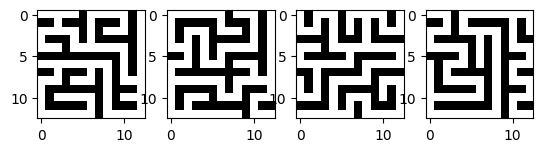

In [12]:
dataiter_test = iter(testLoader)
this_iter_test = next(dataiter_test)
this_iter_test['maze'], this_iter_test['steps']
# mazes, filenames, labels = next(dataiter)
# mazes
# this_iter

fig, axes = plt.subplots(1,4)
axes[0].imshow(this_iter_test['maze'][0].numpy(), cmap='binary')
axes[1].imshow(this_iter_test['maze'][1].numpy(), cmap='binary')
axes[2].imshow(this_iter_test['maze'][2].numpy(), cmap='binary')
axes[3].imshow(this_iter_test['maze'][3].numpy(), cmap='binary')

this_iter_test['steps'][0], this_iter_test['steps'][1], this_iter_test['steps'][2], this_iter_test['steps'][3]

test on running one maze

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


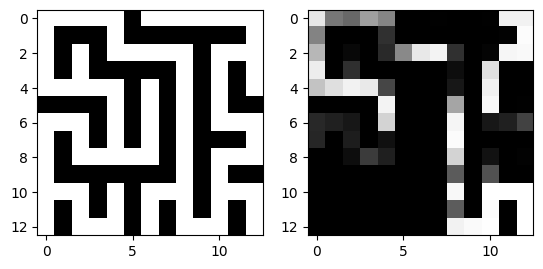

In [13]:
# test on run maze

testMaze=torch.ones(1,n,n)
testSol=torch.ones(n,n)

random_datapoint = random.randint(0, 10000)
testMaze = loaded_data[random_datapoint]['maze'].float().reshape(1,n,n)
testSolved = model(testMaze).detach().numpy()

fig, axes = plt.subplots(1,2)
axes[0].imshow(testMaze[0,:,:],cmap='binary')
axes[1].imshow(testSolved[0,:,:],cmap='binary')

# cells with the minimum number is the most possible move


In [14]:
def transform_tensor_maze(tensor_maze, maze_steps, maze_solution, show_maze = False):
    """ 
    tensor_maze: the direct output from loader, without reshaping
    maze_steps: the direct output from loader (number of steps it take)
    maze_solution: the solution from the loader
    return: (test_torch_maze, test_numpy_maze, test_true_label, row_agent_idx, col_agent_idx)
    """
    test_torch_maze = tensor_maze.float().reshape(1, n, n)
    test_numpy_maze = tensor_maze.numpy()
    # test_true_step = maze_steps.item()
    test_true_step = len(json.loads(maze_solution).keys())

    print(" ==================================================================== ")

    if (show_maze):
        print(f"Testing maze .... ")
        fig = plt.figure()
        fig.add_subplot(111)
        plt.imshow(test_numpy_maze, cmap='binary')
        display(fig)
        plt.close()

    # find the index of the element with value = 2, which is the current location of the agent
    # row_agent_array, col_agent_array = np.where(test_numpy_maze == 2)
    # row_agent_idx = row_agent_array[0]
    # col_agent_idx = col_agent_array[0]

    # starting position of the path
    row_agent_idx = 0
    col_agent_idx = 0

    return (test_torch_maze, test_numpy_maze, test_true_step, row_agent_idx, col_agent_idx)


In [15]:
def find_next_cell(current_row_idx, current_col_idx, test_solved_numpy, explored_set):

    maze_size = test_solved_numpy.shape[0]

    coordinate_array = []
    value_array = []

    # left
    if current_col_idx > 0 and (current_row_idx, current_col_idx - 1) not in explored_set:
        if test_solved_numpy[current_row_idx][current_col_idx-1] < INVALID_BENCHMARK:
            coordinate_array.append((current_row_idx, current_col_idx - 1))
            value_array.append(test_solved_numpy[current_row_idx][current_col_idx-1])
    
    # right
    if current_col_idx < maze_size - 1 and (current_row_idx, current_col_idx + 1) not in explored_set:
        if test_solved_numpy[current_row_idx][current_col_idx+1] < INVALID_BENCHMARK:
            coordinate_array.append((current_row_idx, current_col_idx + 1))
            value_array.append(test_solved_numpy[current_row_idx][current_col_idx+1])

    # up
    if current_row_idx > 0 and (current_row_idx - 1, current_col_idx) not in explored_set:
        if test_solved_numpy[current_row_idx-1][current_col_idx] < INVALID_BENCHMARK:
            coordinate_array.append((current_row_idx - 1 ,current_col_idx))
            value_array.append(test_solved_numpy[current_row_idx-1][current_col_idx])

    # down
    if current_row_idx < maze_size - 1 and (current_row_idx + 1,  current_col_idx) not in explored_set:
        if test_solved_numpy[current_row_idx+1][current_col_idx] < INVALID_BENCHMARK:
            coordinate_array.append((current_row_idx + 1 ,current_col_idx))
            value_array.append(test_solved_numpy[current_row_idx+1][current_col_idx])

    if len(value_array) == 0:
        return None
    
    min_value_idx = np.argmin(value_array)

    return coordinate_array[min_value_idx]

In [16]:
def search_goal(tensor_starting_maze, test_step, test_solution, show_initial_maze = False, show_step = False):
    (test_torch_maze, test_numpy_maze, test_true_step, row_agent_idx, col_agent_idx) = transform_tensor_maze(tensor_starting_maze, test_step, test_solution, show_maze=show_initial_maze)
    # get the solved maze from the model
    test_solved = model(test_torch_maze).detach().numpy()[0] # nxn maze

    # initialise an explored set
    explored = []

    # initialise the starting point
    current_position = (row_agent_idx, col_agent_idx)

    step_count = 0

    while current_position and step_count <= MAX_STEP_ALLOWED:
        explored.append(current_position)
        step_count += 1

        if current_position == (n-1, n-1):
            reached_goal = True

            if show_step:
                path_found = np.ones([n,n])
                for cell in explored:
                    path_found[cell[0], cell[1]] = 0
                print("Path founded ...")
                fig = plt.figure()
                fig.add_subplot(111)
                plt.imshow(path_found, cmap='binary')
                display(fig)
                plt.close()
            
            return(MOVE_RESULT.GOAL, explored, step_count, test_true_step)

        current_position = find_next_cell(current_position[0], current_position[1], test_solved, explored)
        if current_position is None:
            return (MOVE_RESULT.OUT, explored, step_count, test_true_step)
        
        if step_count > MAX_STEP_ALLOWED:
            return (MOVE_RESULT.MAX_STEP_REACHED, explored, step_count, test_true_step)
        
        if test_numpy_maze[current_position[0]][current_position[1]] != 0:
            return (MOVE_RESULT.WALL, explored, step_count, test_true_step)
    

### 2.1 test find goal for one maze

Testing maze .... 


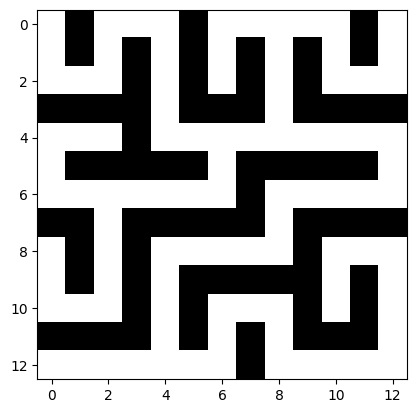

Path founded ...


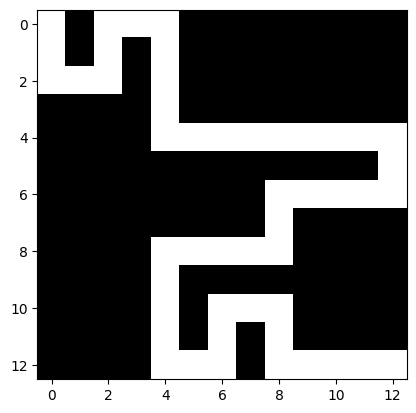

Found goal : MOVE_RESULT.GOAL, Path length: 49, Optimal path length: 49


In [17]:
(reached_goal, explored, step_count, test_step) = search_goal(loaded_data[2]['maze'],loaded_data[2]['steps'], loaded_data[2]['solution'], True, True)
print(f"Found goal : {reached_goal}, Path length: {step_count}, Optimal path length: {test_step}")

### 2.2 test the whole test dataset

In [18]:
def search_goal_testset():
    with torch.no_grad():
        num_total_mazes = 0
        num_found_goal = 0
        num_lost = 0
        num_wall = 0
        num_max_step_reached = 0
        total_squared_error = 0
        total_number_step_accumulated = 0

        for current_data in testLoader:
            mazes = current_data['maze']
            labels = current_data['steps']
            solutions = current_data['solution']
            this_batch_size = len(labels)

            # search goal for this batch
            for i in range(this_batch_size):
                test_starting_tensor_maze = mazes[i]
                test_label = labels[i]
                test_solution = solutions[i]
                (search_result, explored, step_count, test_step) = search_goal(test_starting_tensor_maze, test_label, test_solution,False, False)
                print(f"Found goal : {search_result}, Path length: {step_count}, Optimal path length: {test_step}")

                num_total_mazes += 1

                if search_result == MOVE_RESULT.GOAL:
                    num_found_goal += 1
                    total_squared_error += (test_step - step_count)**2
                    total_number_step_accumulated += step_count
                elif search_result == MOVE_RESULT.MAX_STEP_REACHED:
                    num_max_step_reached += 1
                    total_number_step_accumulated += MAX_STEP_ALLOWED
                elif search_result == MOVE_RESULT.OUT:
                    num_lost += 1
                    total_number_step_accumulated += MAX_STEP_ALLOWED
                elif search_result == MOVE_RESULT.WALL:
                    num_wall += 1
                    total_number_step_accumulated += MAX_STEP_ALLOWED

        
        return {
            "Total test maze counts": num_total_mazes,
            "Num found goal": num_found_goal,
            "Num hit wall, early kill": num_wall,
            "Num max step reached": num_max_step_reached,
            "Num get lost, disconnected": num_lost,
            "MSE for ones reached goal": total_squared_error/num_found_goal,
            "Average number of steps take to find path": total_number_step_accumulated/num_total_mazes
        }

In [19]:
test_find_goal_result = search_goal_testset()
test_find_goal_result

Found goal : MOVE_RESULT.GOAL, Path length: 25, Optimal path length: 25
Found goal : MOVE_RESULT.OUT, Path length: 7, Optimal path length: 37
Found goal : MOVE_RESULT.GOAL, Path length: 49, Optimal path length: 49
Found goal : MOVE_RESULT.GOAL, Path length: 85, Optimal path length: 85
Found goal : MOVE_RESULT.OUT, Path length: 28, Optimal path length: 33
Found goal : MOVE_RESULT.OUT, Path length: 13, Optimal path length: 57
Found goal : MOVE_RESULT.GOAL, Path length: 57, Optimal path length: 57
Found goal : MOVE_RESULT.GOAL, Path length: 33, Optimal path length: 33
Found goal : MOVE_RESULT.OUT, Path length: 52, Optimal path length: 45
Found goal : MOVE_RESULT.WALL, Path length: 21, Optimal path length: 25
Found goal : MOVE_RESULT.OUT, Path length: 16, Optimal path length: 37
Found goal : MOVE_RESULT.GOAL, Path length: 37, Optimal path length: 37
Found goal : MOVE_RESULT.OUT, Path length: 32, Optimal path length: 49
Found goal : MOVE_RESULT.GOAL, Path length: 33, Optimal path length: 33

{'Total test maze counts': 10000,
 'Num found goal': 3652,
 'Num hit wall, early kill': 2551,
 'Num max step reached': 0,
 'Num get lost, disconnected': 3797,
 'MSE for ones reached goal': 0.0,
 'Average number of steps take to find path': 73.8172}

In [20]:
found_goal_rate = test_find_goal_result["Num found goal"]/test_find_goal_result["Total test maze counts"]*100
print(f"Goal Rate: {found_goal_rate}%")

Goal Rate: 36.52%
